In [1]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor)
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    RandomizedSearchCV,
    KFold,
    train_test_split)
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from math import sqrt

In [108]:
class base:
    def __init__(self, **kwargs):
        self.features = kwargs["features"]
        self.response = kwargs["response"]

    def preProcess_features(self, **kwargs):
        if "rescale_type" not in kwargs.keys():
            standardized = preprocessing.StandardScaler()
            features_processed = standardized.fit_transform(np.array(self.features))
        elif kwargs["rescale_type"] == "norm":
            norm = preprocessing.MinMaxScaler()
            features_processed = norm.fit_transform(np.array(self.features))
        else:
            print(str(kwargs["rescale_type"])+ "rescaling technique not implemented \n Defaulting to standardized variables")
            standardized = preprocessing.StandardScaler()
            features_processed = standardized.fit_transform(np.array(self.features))

        self.features_processed = features_processed
        return features_processed

    def predict(self, **kwargs):
        features_to_predict = kwargs["features"]
        self.predictions = self.model.predict(features_to_predict)

    def run_CVs(self, **kwargs):

        standardized = preprocessing.StandardScaler()
        norm = preprocessing.MinMaxScaler()

        x_data = kwargs["features"]

        # Normalise or standardize, two different forms of rescaling
        if "rescale_type" not in kwargs.keys():
            x_data = standardized.fit_transform(np.array(x_data))
        elif kwargs["rescale_type"] == "norm":
            x_data = norm.fit_transform(np.array(x_data))
        else:
            print("rescaling technique not implemented \n Defaulting to standardized variables")
            x_data = standardized.fit_transform(np.array(x_data))

        y_data = np.array(kwargs["response"])
        n_folds = kwargs["n_folds"]
        title = kwargs["title"]

        kf = KFold(n_splits=n_folds)
        df = {}
        fold_indices = {}

        count = 1
        for train_index, test_index in kf.split(x_data):
            X_train, X_test = x_data[train_index], x_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]

            model_cv = kwargs["model_type"]
            model_cv.fit(X_train, y_train)

            fold = model_cv.predict(X_test)
            df[f"Pred{count}"] = fold
            df[f"Obs{count}"] = y_test

            fold_indices[f"Train{count}"] = train_index
            fold_indices[f"Test{count}"] = test_index

            count += 1

        fig = plt.figure(figsize=(20, 15))

        count = 1

        comb_cv_obs = []
        comb_cv_preds = []

        # Wether or not to visualise the cross validation
        try:
            visualize = kwargs["visualize"]
        except:
            visualize = None

        if visualize:
            for i in range(n_folds):
                print(i)
                print(f"23{count}")
                ax = fig.add_subplot(5,2,count)
                sns.regplot(x=df[f"Obs{count}"], y=df[f"Pred{count}"])
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)
                ax.set_ylabel("Predicted")
                ax.set_xlabel("Observed")
                ax.set_title(f"Fold{count}")
                r_val, pval = spearmanr(df[f"Obs{count}"], df[f"Pred{count}"])
                r2_val = round(r_val ** 2, 2)
                x_cord, y_cord = max(df[f"Obs{count}"]) * 0.15, max(df[f"Pred{count}"])
                ax.annotate(f"$R^2 = {r2_val}$", (x_cord, y_cord))

                comb_cv_preds.extend(df[f"Pred{count}"])
                comb_cv_obs.extend(df[f"Obs{count}"])

                count += 1

            R, pVal = spearmanr(comb_cv_obs, comb_cv_preds)
            R2 = round(R ** 2, 2)

            fig.suptitle(f"{title} (Combined data $R^2$ = {R2})")
            plt.tight_layout()
            direc = os.getcwd()
            out_direc = f"{direc}"
            os.makedirs(out_direc, exist_ok=True)
            plt.savefig(f'{out_direc}/Fold_{title}.png')
            plt.savefig(f'{out_direc}/Fold_{title}.svg')
            plt.show()

            fig2 = plt.figure(figsize=(12, 10))
            ax2 = fig2.add_subplot(111)
            sns.regplot(x=comb_cv_obs, y=comb_cv_preds, ax=ax2)
            ax2.spines["top"].set_visible(False)
            ax2.spines["right"].set_visible(False)
            ax2.set_title(title, pad=10)
            r, pval = spearmanr(comb_cv_obs, comb_cv_preds)
            r2 = round(r ** 2, 2)
            x_coord = max(comb_cv_obs) * 0.75
            y_coord = max(comb_cv_preds) * 0.99
            ax2.text(x_coord, y_coord, f"$R^2 = {round(r2,2)}$")
            ax2.set_xlabel("Observations", labelpad=20)
            ax2.set_ylabel("Predictions", labelpad=20)
            fig2.tight_layout()
            fig2.savefig(f'{out_direc}/crossVal_SVR.png') 
            fig2.savefig(f'{out_direc}/crossVal_SVR.svg')

        return df, fold_indices

In [109]:
class LR(base):

    """ Linear Regression Model """

    def train_lr(self, **kwargs):
        model = LinearRegression()

        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=LinearRegression(),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=None)

        return df, fold_indices


class RF(base):

    """" Random Forest Regression Model """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))


    def grid_search(self, **kwargs):
        n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
        max_features = [1, 2, 3, 4,5,6,7,8,9,10]
        max_depth = [int(x) for x in np.linspace(10, stop=100, num=11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [10, 15, 20]
        bootstrap = [True, False]
        random_grid = {
            "n_estimators": n_estimators,
            "max_features": max_features,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "bootstrap": bootstrap}
       
        rf = RandomForestRegressor()
       
        rf_random = RandomizedSearchCV(
            estimator=rf,
            param_distributions=random_grid,
            n_iter=100,
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1)
        rf_random.fit(self.features_processed, self.response)
        print(rf_random.best_params_)

        self.ran_params = rf_random.best_params_

    def train_rf(self, **kwargs):
        model = RandomForestRegressor(
            n_estimators=self.ran_params["n_estimators"],
            min_samples_leaf=self.ran_params["min_samples_leaf"],
            min_samples_split=self.ran_params["min_samples_split"],
            max_features=self.ran_params["max_features"],
            max_depth=self.ran_params["max_depth"],
            bootstrap=self.ran_params["bootstrap"])

        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=RandomForestRegressor(
                n_estimators=self.ran_params["n_estimators"],
                min_samples_leaf=self.ran_params["min_samples_leaf"],
                min_samples_split=self.ran_params["min_samples_split"],
                max_features=self.ran_params["max_features"],
                max_depth=self.ran_params["max_depth"],
                bootstrap=self.ran_params["bootstrap"]),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])

        return df, fold_indices

    def feature_importance(self, **kwargs):

        importances = self.model.feature_importances_
        self.feature_importance_std = np.std([tree.feature_importances_ for tree in self.model.estimators_], axis=0)
        return importances

In [98]:
crawfordsville=pd.read_csv("Data/Crawfordsville/UAV/RGBuav_Crawfordsville_TP1.csv", index_col=0)

In [99]:
crawfordsville=crawfordsville.iloc[:,list(range(1, 16))+[21]]

In [100]:
crawfordsville=crawfordsville.dropna()

In [101]:
crawfordsville

,Red_mean,Red_median,Red_sum,Green_mean,Green_median,Green_sum,Blue_mean,Blue_median,Blue_sum,GLI_mean,GLI_median,GLI_sum,NGRDI_mean,NGRDI_median,NGRDI_sum,yieldPerAcre
0,90.953899,89.0,19948100,136.731220,140.0,29988028,85.966524,82.0,18854264,0.229436,0.228571,50320.158603,0.205981,0.209877,45175.862361,176.76
2,104.293481,106.0,24860750,140.526154,147.0,33497641,94.068028,94.0,22423278,0.179925,0.175325,42889.368357,0.146643,0.149485,34955.647285,168.98
3,88.796322,87.0,20181184,130.104437,133.0,29569486,82.442006,80.0,18737007,0.216942,0.216667,49305.574583,0.189910,0.194690,43161.714439,146.21
4,85.061262,82.0,18897125,126.374317,127.0,28075192,77.742873,73.0,17271279,0.227862,0.233449,50621.649910,0.196670,0.208633,43691.938958,173.06
5,121.519739,126.0,30436563,156.895040,168.0,39296873,106.170131,110.0,26592008,0.164518,0.158756,41206.163508,0.123339,0.124183,30892.103032,112.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,105.721217,108.0,22566828,156.233275,167.0,33348930,99.089794,99.0,21151311,0.222046,0.220690,47396.976247,0.197634,0.202247,42186.140713,149.61
518,98.715803,98.0,21893783,143.503174,150.0,31826995,94.301822,92.0,20914824,0.209354,0.207273,46431.889108,0.188429,0.192308,41790.941390,149.43
519,113.226704,116.0,26004777,157.012457,168.0,36061051,100.945439,103.0,23184139,0.200972,0.195079,46157.237363,0.165773,0.166667,38073.196300,169.02
520,101.245747,102.0,22395053,148.228210,156.0,32787339,89.727824,88.0,19847346,0.232182,0.226766,51357.578788,0.192713,0.195652,42627.165967,169.93


In [102]:
feature=crawfordsville.iloc[:,list(range(0, 15))].values

In [103]:
response=crawfordsville.iloc[:,15].values

In [104]:
crawfordsville.columns

Index(['Red_mean', 'Red_median', 'Red_sum', 'Green_mean', 'Green_median',
       'Green_sum', 'Blue_mean', 'Blue_median', 'Blue_sum', 'GLI_mean',
       'GLI_median', 'GLI_sum', 'NGRDI_mean', 'NGRDI_median', 'NGRDI_sum',
       'yieldPerAcre'],
      dtype='object')

In [72]:
# Create an instance of the base class
base_instance = base(response=response,features=feature)

# Call the preProcess_features method on the instance
preprocessed_features = base_instance.preProcess_features(rescale_type=None)

Nonerescaling technique not implemented 
 Defaulting to standardized variables


Nonerescaling technique not implemented 
 Defaulting to standardized variables
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=46, max_features=4, min_samples_leaf=20, min_samples_split=5, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=91, max_features=7, min_samples_leaf=10, min_samples_split=5, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=19, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=19, max_features=6, min_samples_leaf=15, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END bootstrap=True, max_depth=28, max_features=9, min_samples_leaf=15, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END bootstrap=True, max_depth=55, max_features=10, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=46, max_featur

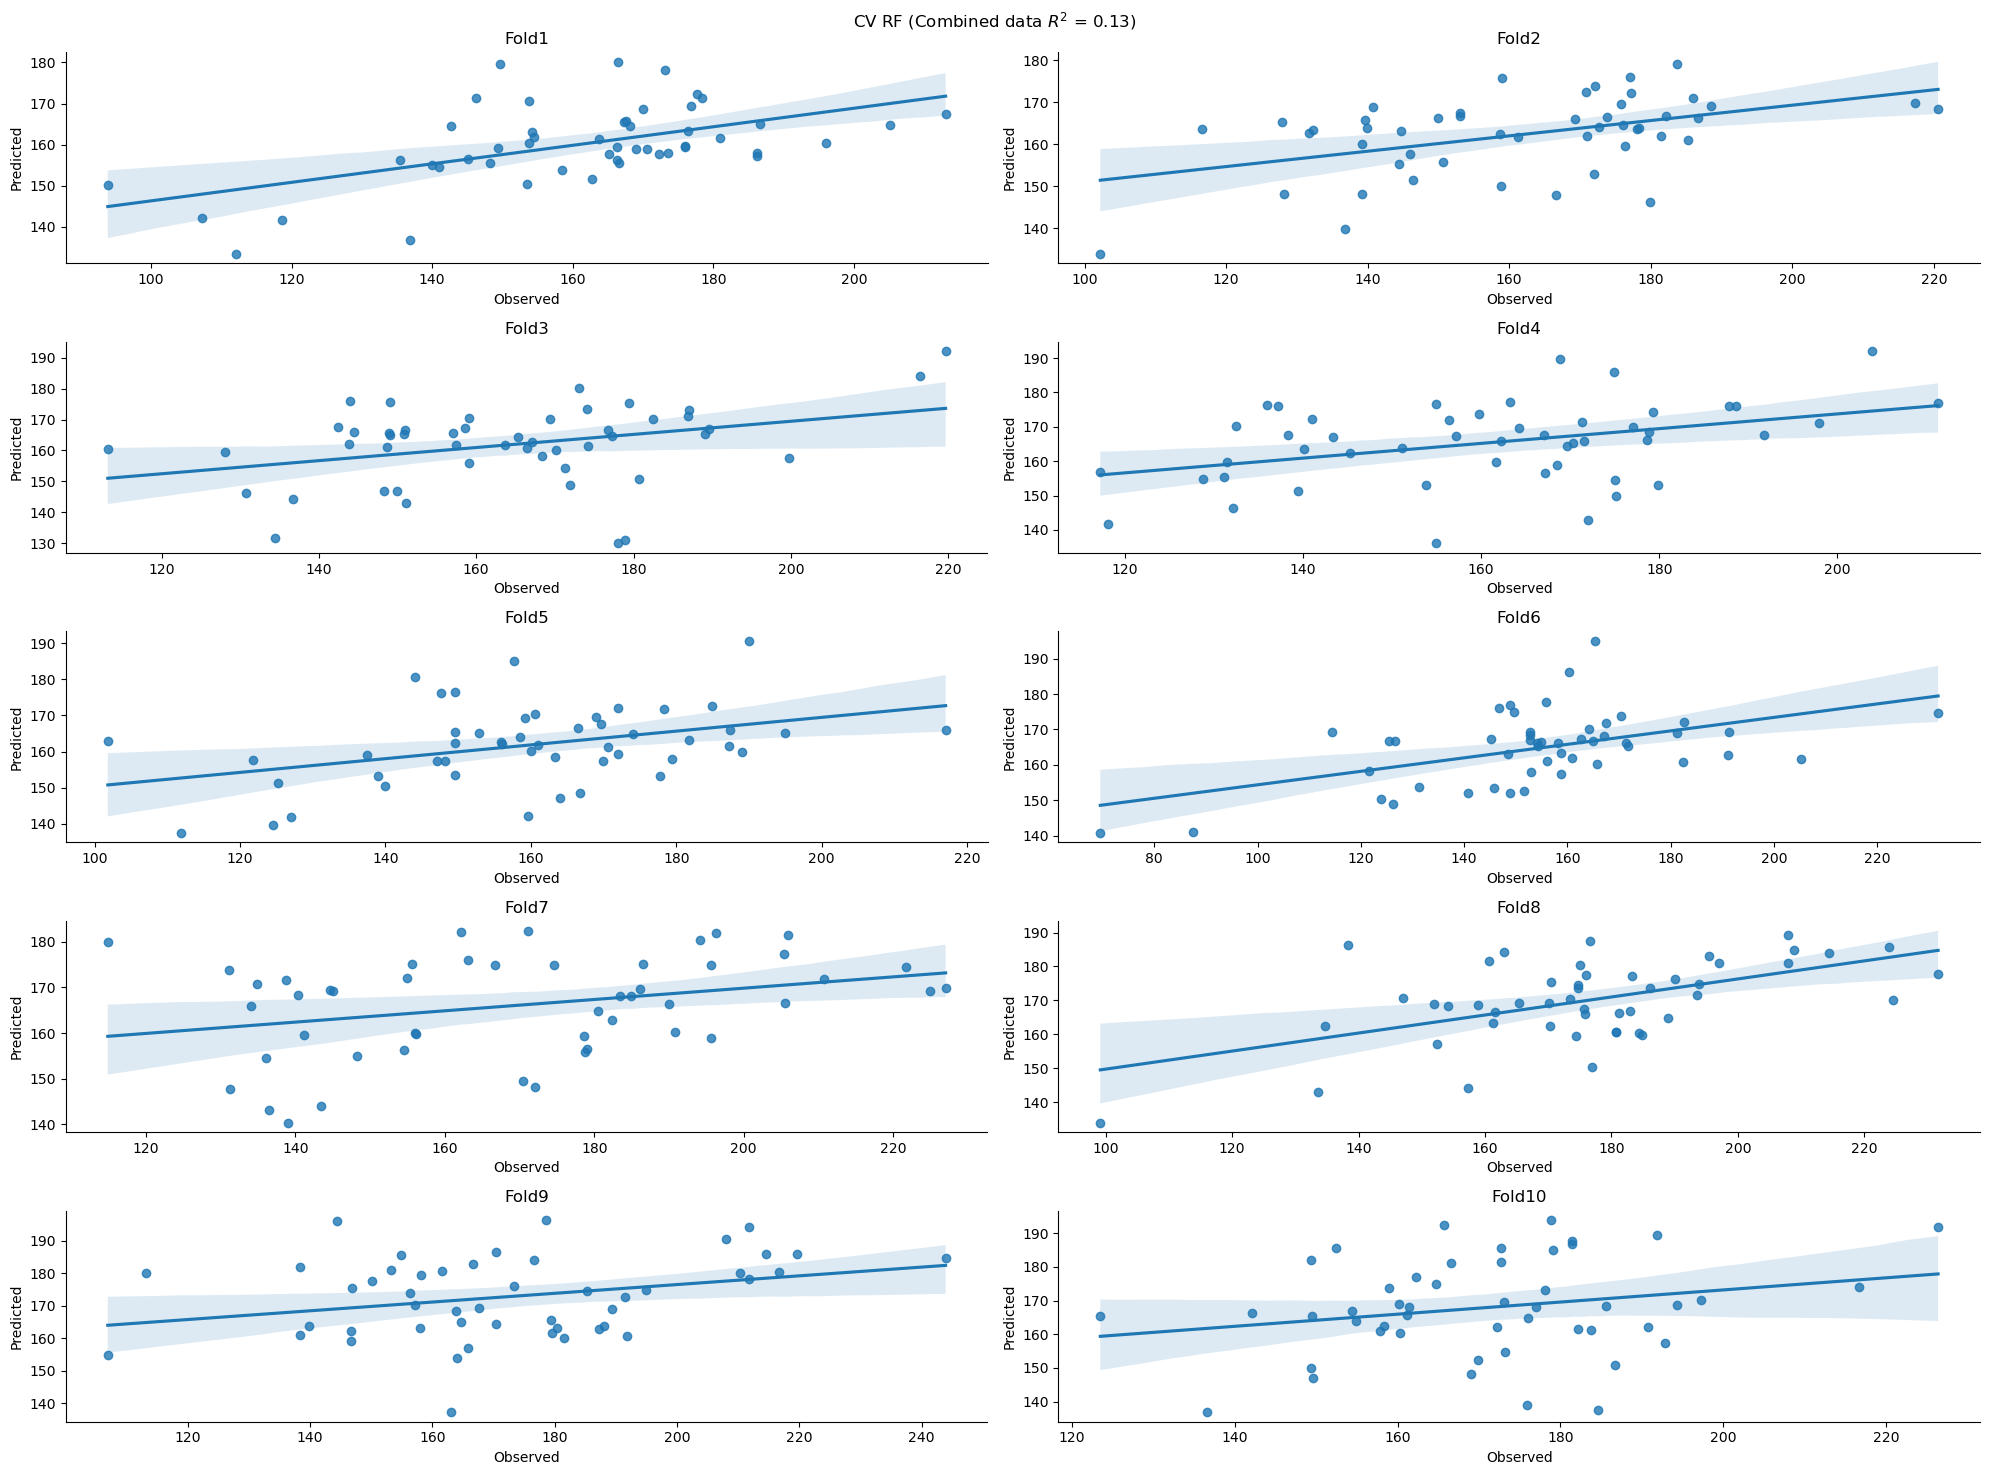

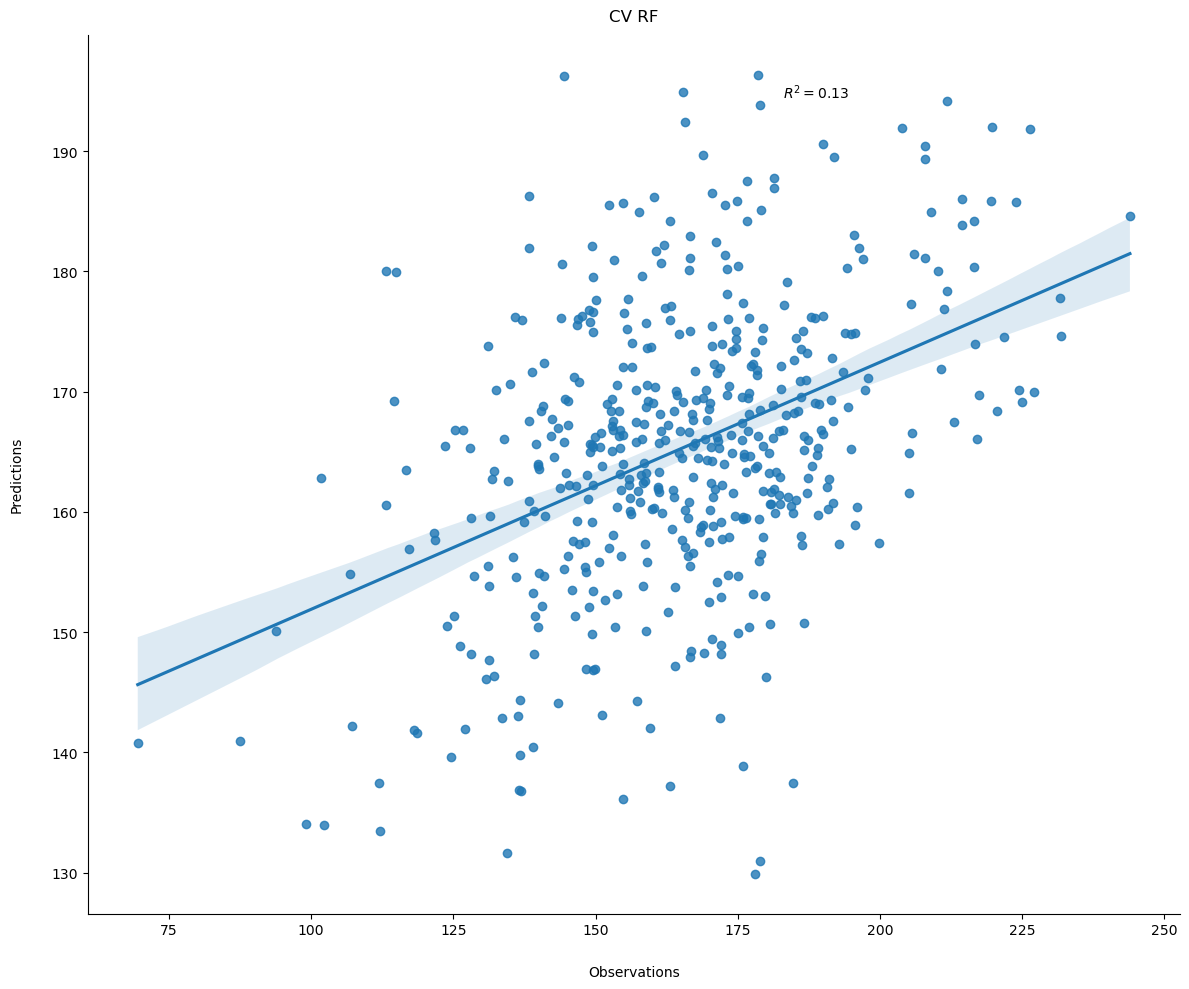

In [110]:
model=RF(response=response,features=feature,rescale_type=None)
model.grid_search()
results,nfolds=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="CV RF")